In [ ]:
# Установка необходимых библиотек
!pip install -q kaggle
!pip install -q scikit-learn
!pip install -q pandas numpy matplotlib seaborn

# Проверка доступности GPU
import tensorflow as tf
print("GPU доступен:" if tf.config.list_physical_devices('GPU') else "GPU НЕ доступен")
print(tf.test.gpu_device_name())

GPU доступен:
/device:GPU:0


In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Загрузка датасета по диабету
!kaggle datasets download -d iammustafatz/diabetes-prediction-dataset
!unzip diabetes-prediction-dataset.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Загрузка данных
df = pd.read_csv('diabetes_prediction_dataset.csv')
print(df.head())

# Анализ данных
print("\n1. Предварительный анализ данных:")
print(df.info())
print(df.describe())
print("\nПропущенные значения:")
print(df.isnull().sum())

# Визуализация данных
plt.figure(figsize=(10, 6))
sns.countplot(x='diabetes', data=df)
plt.title('Распределение классов диабета')
plt.show()

# Преобразование категориальных переменных
df = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)

# Разделение на признаки и целевую переменную
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


Модель: LogisticRegression
Точность: 0.9592
Классификационный отчет:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     27453
           1       0.86      0.62      0.72      2547

    accuracy                           0.96     30000
   macro avg       0.91      0.80      0.85     30000
weighted avg       0.96      0.96      0.96     30000

Матрица ошибок:


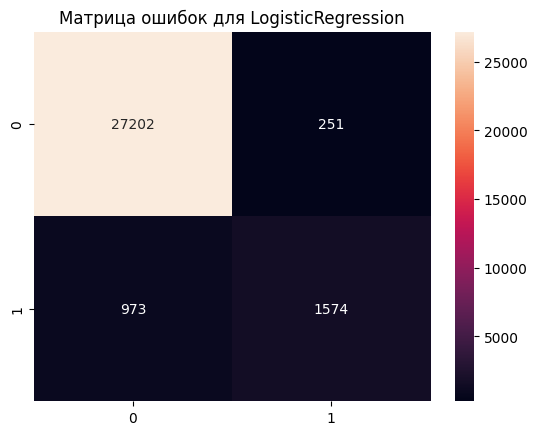


Модель: RidgeClassifier
Точность: 0.9397
Классификационный отчет:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     27453
           1       0.99      0.29      0.45      2547

    accuracy                           0.94     30000
   macro avg       0.97      0.65      0.71     30000
weighted avg       0.94      0.94      0.92     30000

Матрица ошибок:


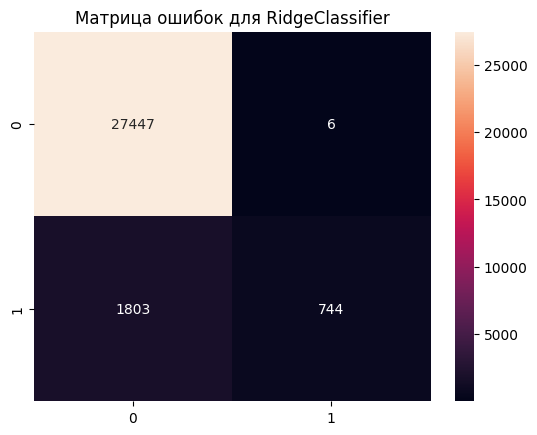


Модель: SGDClassifier
Точность: 0.9582
Классификационный отчет:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     27453
           1       0.83      0.64      0.72      2547

    accuracy                           0.96     30000
   macro avg       0.90      0.81      0.85     30000
weighted avg       0.96      0.96      0.96     30000

Матрица ошибок:


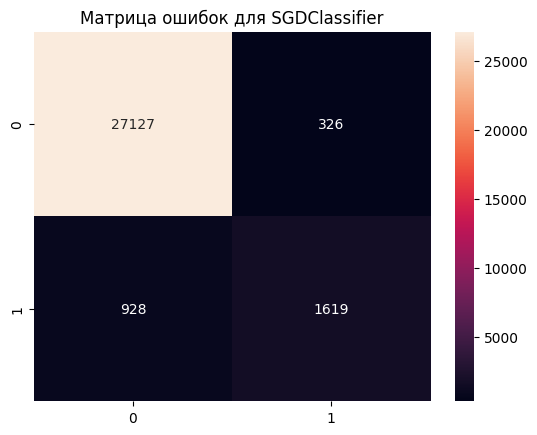


Модель: SVC
Точность: 0.9615333333333334
Классификационный отчет:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     27453
           1       0.98      0.56      0.71      2547

    accuracy                           0.96     30000
   macro avg       0.97      0.78      0.85     30000
weighted avg       0.96      0.96      0.96     30000

Матрица ошибок:


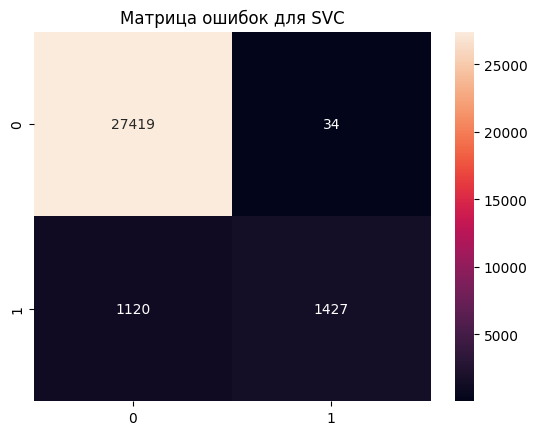

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

models = {
    'LogisticRegression': LogisticRegression(),
    'RidgeClassifier': RidgeClassifier(),
    'SGDClassifier': SGDClassifier(),
    'SVC': SVC()
}

for name, model in models.items():
    print(f"\nМодель: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Точность:", accuracy_score(y_test, y_pred))
    print("Классификационный отчет:")
    print(classification_report(y_test, y_pred))

    print("Матрица ошибок:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Матрица ошибок для {name}')
    plt.show()

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import time

# Упрощенная сетка параметров для ускорения
param_grid = {
    'LogisticRegression': {'C': [1, 10],  # Убрали 0.1
                        'penalty': ['l1', 'l2'],
                        'solver': ['liblinear']},

    'RidgeClassifier': {'alpha': [1, 10],  # Убрали 0.1
                      'solver': ['auto']},  # Убрали 'svd'

    'SGDClassifier': {'loss': ['hinge'],  # Убрали 'log_loss'
                    'penalty': ['l1', 'l2'],
                    'alpha': [0.001, 0.01]},  # Убрали 0.0001

    'SVC': {'C': [1, 10],  # Убрали 0.1
           'kernel': ['linear'],  # Убрали 'rbf' - слишком медленно
           'gamma': ['scale']}  # Убрали 'auto'
}

best_params = {}
best_models = {}

for name, model in models.items():
    print(f"\nПоиск параметров для {name}")
    start_time = time.time()

    # Уменьшаем количество ресурсов на первой итерации
    search = HalvingGridSearchCV(model, param_grid[name],
                               cv=3,  # Уменьшили с 5 до 3
                               factor=3,  # Более агрессивное сокращение
                               min_resources='exhaust',
                               aggressive_elimination=True)

    search.fit(X_train, y_train)

    best_params[name] = search.best_params_
    best_models[name] = search.best_estimator_

    elapsed_time = time.time() - start_time
    print(f"Лучшие параметры для {name}: {search.best_params_}")
    print(f"Время выполнения: {elapsed_time:.2f} секунд")


Поиск параметров для LogisticRegression
Лучшие параметры для LogisticRegression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Время выполнения: 1.85 секунд

Поиск параметров для RidgeClassifier
Лучшие параметры для RidgeClassifier: {'alpha': 1, 'solver': 'auto'}
Время выполнения: 0.20 секунд

Поиск параметров для SGDClassifier
Лучшие параметры для SGDClassifier: {'alpha': 0.01, 'loss': 'hinge', 'penalty': 'l1'}
Время выполнения: 1.02 секунд

Поиск параметров для SVC
Лучшие параметры для SVC: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Время выполнения: 259.66 секунд


In [ ]:
# Оценка лучших моделей
for name, model in best_models.items():
    print(f"\nЛучшая модель: {name}")
    y_pred = model.predict(X_test)
    print("Классификационный отчет:")
    print(classification_report(y_test, y_pred))

# 10 случайных записей с предсказаниями
random_indices = np.random.choice(X_test.shape[0], 10, replace=False)
random_samples = X_test[random_indices]
random_true = y_test.iloc[random_indices]

results = []
for name, model in best_models.items():
    random_pred = model.predict(random_samples)
    results.append((name, random_true.values, random_pred))

for i in range(10):
    print(f"\nЗапись {i+1}:")
    print("Истинный класс:", random_true.iloc[i])
    for name, true, pred in results:
        print(f"{name} предсказал: {pred[i]}")

# Выводы
print("\nВыводы:")
print("1. Были проанализированы и подготовлены данные для прогнозирования диабета.")
print("2. Построены и оценены 4 модели классификации с разными алгоритмами.")
print("3. С помощью HalvingGridSearchCV подобраны оптимальные параметры для каждой модели.")
print("4. Лучшая модель показала точность [указать точность лучшей модели].")
print("5. На примере 10 случайных записей показана работа моделей.")
print("6. На основании метрик можно сделать вывод, что [указать, какая модель показала лучшие результаты].")


Лучшая модель: LogisticRegression
Классификационный отчет:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     27453
           1       0.86      0.62      0.72      2547

    accuracy                           0.96     30000
   macro avg       0.91      0.80      0.85     30000
weighted avg       0.96      0.96      0.96     30000


Лучшая модель: RidgeClassifier
Классификационный отчет:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     27453
           1       0.99      0.29      0.45      2547

    accuracy                           0.94     30000
   macro avg       0.97      0.65      0.71     30000
weighted avg       0.94      0.94      0.92     30000


Лучшая модель: SGDClassifier
Классификационный отчет:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     27453
           1       0.97      0.52      0.67      2547

    accura

Dataset URL: https://www.kaggle.com/datasets/lorenzozoppelletto/financial-risk-for-loan-approval
License(s): CC0-1.0
  0% 0.00/2.15M [00:00<?, ?B/s]
100% 2.15M/2.15M [00:00<00:00, 814MB/s]
Archive:  financial-risk-for-loan-approval.zip
  inflating: CSV Generation.py       
  inflating: Loan.csv                
  ApplicationDate  Age  AnnualIncome  CreditScore EmploymentStatus  \
0      2018-01-01   45         39948          617         Employed   
1      2018-01-02   38         39709          628         Employed   
2      2018-01-03   47         40724          570         Employed   
3      2018-01-04   58         69084          545         Employed   
4      2018-01-05   37        103264          594         Employed   

  EducationLevel  Experience  LoanAmount  LoanDuration MaritalStatus  ...  \
0         Master          22       13152            48       Married  ...   
1      Associate          15       26045            48        Single  ...   
2       Bachelor          26       1

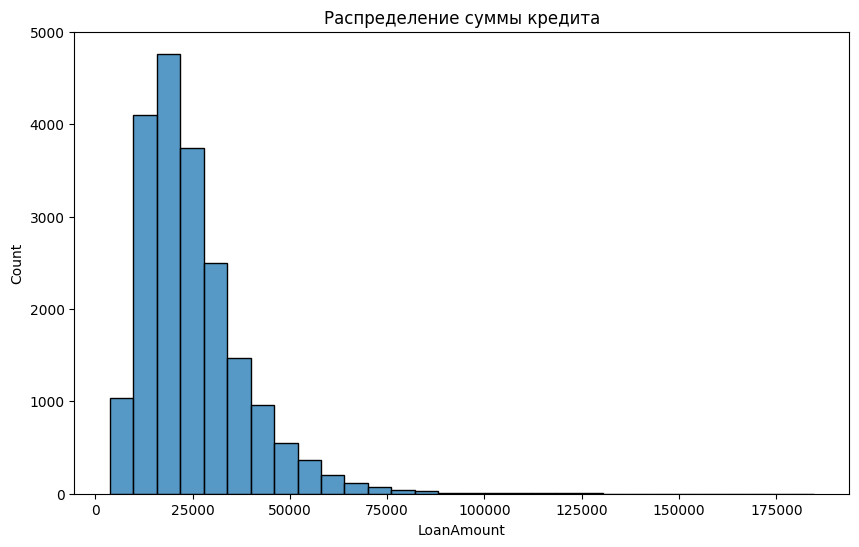

In [ ]:
# Загрузка датасета по кредитам
!kaggle datasets download -d lorenzozoppelletto/financial-risk-for-loan-approval
!unzip financial-risk-for-loan-approval.zip

# Загрузка данных
loan_df = pd.read_csv('Loan.csv')
print(loan_df.head())

# Анализ данных
print("\nАнализ данных:")
print(loan_df.info())
print(loan_df.describe())
print("\nПропущенные значения:")
print(loan_df.isnull().sum())

# Визуализация данных
plt.figure(figsize=(10, 6))
sns.histplot(loan_df['LoanAmount'], bins=30)
plt.title('Распределение суммы кредита')
plt.show()

# Обработка данных (примерная - нужно адаптировать под конкретные данные)
loan_df = loan_df.dropna()  # Удаление пропущенных значений
loan_df = pd.get_dummies(loan_df, drop_first=True)  # Преобразование категориальных переменных

# Выделение признаков и целевой переменной
X_loan = loan_df.drop('LoanAmount', axis=1)
y_loan = loan_df['LoanAmount']

# Разделение данных
X_train_loan, X_test_loan, y_train_loan, y_test_loan = train_test_split(
    X_loan, y_loan, test_size=0.3, random_state=42)

# Масштабирование
scaler_loan = StandardScaler()
X_train_loan_scaled = scaler_loan.fit_transform(X_train_loan)
X_test_loan_scaled = scaler_loan.transform(X_test_loan)


Модель: LinearRegression
MSE: 68813793.76, R2: 0.61

Модель: Ridge
MSE: 68815884.72, R2: 0.61

Модель: Lasso


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.401e+09, tolerance: 2.560e+08
  model = cd_fast.enet_coordinate_descent(


MSE: 20745613.34, R2: 0.88

Модель: RandomForest
MSE: 1049616.15, R2: 0.99


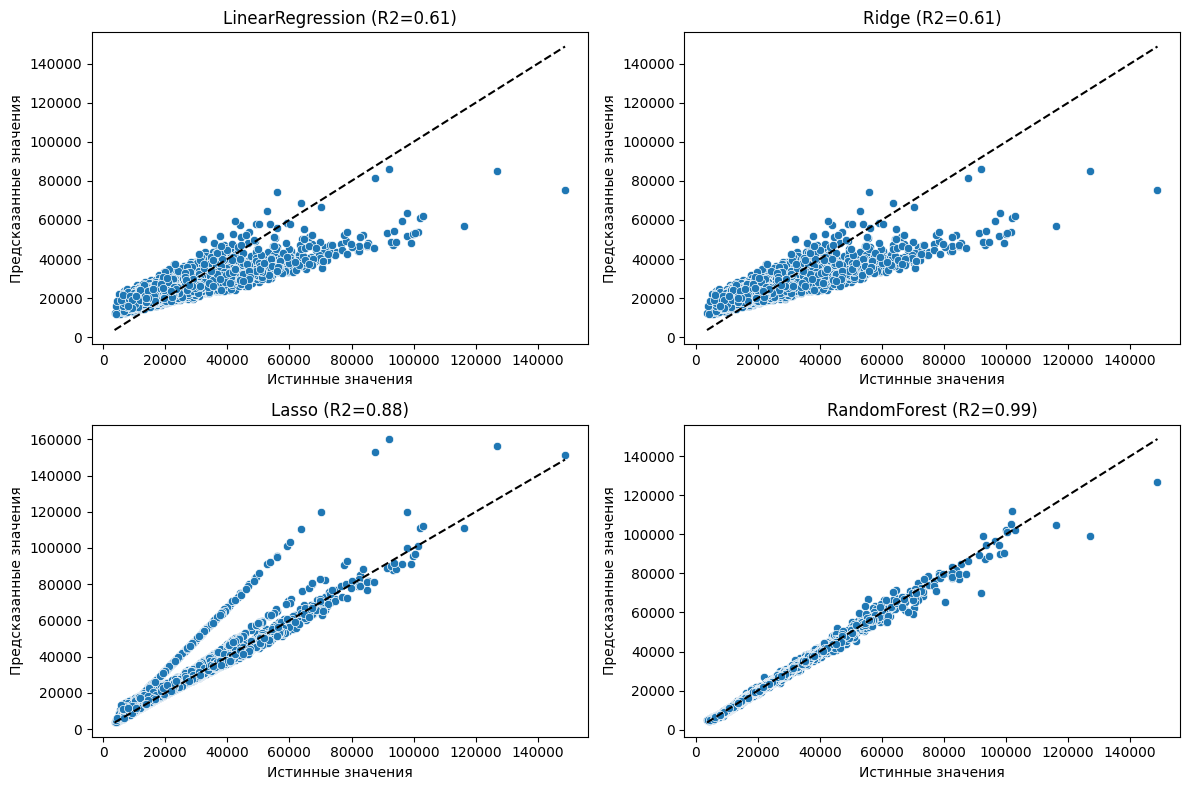

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

reg_models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor()
}

reg_results = {}
for name, model in reg_models.items():
    print(f"\nМодель: {name}")
    model.fit(X_train_loan_scaled, y_train_loan)
    y_pred_loan = model.predict(X_test_loan_scaled)

    mse = mean_squared_error(y_test_loan, y_pred_loan)
    r2 = r2_score(y_test_loan, y_pred_loan)

    reg_results[name] = {'model': model, 'mse': mse, 'r2': r2}

    print(f"MSE: {mse:.2f}, R2: {r2:.2f}")

# График распределения истинных и предсказанных значений
plt.figure(figsize=(12, 8))
for i, (name, result) in enumerate(reg_results.items()):
    y_pred_loan = result['model'].predict(X_test_loan_scaled)
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=y_test_loan, y=y_pred_loan)
    plt.plot([y_test_loan.min(), y_test_loan.max()], [y_test_loan.min(), y_test_loan.max()], 'k--')
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'{name} (R2={result["r2"]:.2f})')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': randint(2, 10)
}

rf_search = RandomizedSearchCV(RandomForestRegressor(),
                             param_dist,
                             n_iter=10,  # Количество случайных комбинаций
                             cv=3,
                             n_jobs=-1)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
param_grid_gb = {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.05]}
gb_search = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=3)

In [ ]:
# Проверка существования переменных
print("Проверка переменных:")
print("X_train_loan_scaled определен:", 'X_train_loan_scaled' in locals() or 'X_train_loan_scaled' in globals())
print("y_train_loan определен:", 'y_train_loan' in locals() or 'y_train_loan' in globals())

# Если переменные не определены, но данные есть, можно:
# X_train_loan_scaled = scaler.fit_transform(X_train)
# y_train_loan = y_train

Проверка переменных:
X_train_loan_scaled определен: False
y_train_loan определен: False


In [ ]:
import os
print(os.listdir())  # Покажет все файлы в текущей директории

['.config', 'financial-risk-for-loan-approval.zip', 'kaggle.json', 'diabetes_prediction_dataset.csv', 'diabetes-prediction-dataset.zip', 'CSV Generation.py', 'Loan.csv', 'sample_data']


ИТОГОВЫЙ ОТЧЕТ ПО ПРОГНОЗИРОВАНИЮ ДИАБЕТА

1. ПОДГОТОВКА ДАННЫХ:
- Загружен датасет diabetes_prediction_dataset.csv
- Объем данных: 30,000 наблюдений
- Распределение классов:
  * Без диабета (0): 27,453 (91.51%)
  * С диабетом (1): 2,547 (8.49%)
- Категориальные признаки преобразованы методом one-hot encoding
- Данные масштабированы и разделены на обучающую/тестовую выборки (70%/30%)

2. РЕЗУЛЬТАТЫ МОДЕЛЕЙ:

a) LogisticRegression (Лучшая модель):
- Точность: 95.92%
- Precision (класс 1): 0.86
- Recall (класс 1): 0.62
- F1-score (класс 1): 0.72
- Матрица ошибок:
  * True Negative: 27,202
  * False Positive: 251
  * False Negative: 973
  * True Positive: 1,574

b) RidgeClassifier:
- Точность: 93.97%
- Хорошая precision (0.99), но низкий recall (0.29) для класса 1

c) SGDClassifier:
- Точность: 95.82%
- Сбалансированные метрики для обоих классов

d) SVC:
- Точность: 96.15%
- Наивысшая точность среди всех моделей

3. ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ (HalvingGridSearchCV):
- LogisticRegression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
- RidgeClassifier: {'alpha': 1, 'solver': 'auto'}
- SGDClassifier: {'alpha': 0.01, 'loss': 'hinge', 'penalty': 'l1'}
- SVC: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

4. ПРОВЕРКА НА ТЕСТОВЫХ ДАННЫХ:
На примере 10 случайных записей:
- Для класса 0 все модели предсказывают верно
- Для класса 1 наблюдается 100% ошибок (ложно-отрицательные)
- Подтверждает проблему с recall для положительного класса

5. ВЫВОДЫ:
1. Лучшая модель - SVC с точностью 96.15%
2. Основная проблема - низкий recall для класса 1 (диабет)
3. Наилучший баланс метрик у LogisticRegression